In [6]:
!uv venv

Using CPython 3.11.6
Creating virtual environment at: .venv
Activate with: .venv\Scripts\activate


In [9]:
!.venv\Scripts\activate

In [12]:
!pip3 install -U ucimlrepo 

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [22]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

In [43]:
from ucimlrepo import fetch_ucirepo
adult = fetch_ucirepo(id=2)
X = adult.data.features
y = adult.data.targets

In [44]:
X.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba


In [45]:
X = adult.data.features.copy()
y = adult.data.targets.squeeze()
# Normalize target tokens (Adult dataset has whitespace/dot variants)
y = y.astype(str).str.strip().str.replace('.', '', regex=False)

In [46]:
# Normalize missing value tokens before imputation
X = X.replace(["?", " ?"], np.nan) 
missing_counts = X.isna().sum().sort_values(ascending=False)
missing_counts[missing_counts > 0]

occupation        2809
workclass         2799
native-country     857
dtype: int64

drop NA

In [47]:
na_free = X.notna().all(axis=1)
X = X.loc[na_free].copy()
y = y.loc[na_free].copy()
missing_counts = X.isna().sum().sort_values(ascending=False)
missing_counts[missing_counts > 0]

Series([], dtype: int64)

Using Label Encoder

In [ ]:
target_encoder = LabelEncoder()
y = pd.Series(target_encoder.fit_transform(y), index=y.index, name="income")
y.value_counts(normalize=True)

In [49]:
#extract categorical and numberic columns
cat_cols = X.select_dtypes(include="object").columns
num_cols = X.select_dtypes(include="number").columns

In [50]:
label_encoders = {}
for col in cat_cols:
    encoder = LabelEncoder()
    X[col] = encoder.fit_transform(X[col])
    label_encoders[col] = encoder
X[cat_cols].head()

,workclass,education,marital-status,occupation,relationship,race,sex,native-country
0,5,9,4,0,1,4,1,38
1,4,9,2,3,0,4,1,38
2,2,11,0,5,1,4,1,38
3,2,1,2,5,0,2,1,38
4,2,9,2,9,5,2,0,4


In [51]:
X.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,5,77516,9,13,4,0,1,4,1,2174,0,40,38
1,50,4,83311,9,13,2,3,0,4,1,0,0,13,38
2,38,2,215646,11,9,0,5,1,4,1,0,0,40,38
3,53,2,234721,1,7,2,5,0,2,1,0,0,40,38
4,28,2,338409,9,13,2,9,5,2,0,0,0,40,4


In [52]:
from sklearn.model_selection import train_test_split

# first we make holdout then split holdout into validation and test (60/20/20)
X_train, X_holdout, y_train, y_holdout = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_holdout, y_holdout, test_size=0.5, random_state=42, stratify=y_holdout
)

print(f"Train: {len(X_train)} rows")
print(f"Validation: {len(X_val)} rows")
print(f"Test: {len(X_test)} rows")

Train: 27133 rows
Validation: 9044 rows
Test: 9045 rows


Bulilding the tree

In [53]:
feature_names = X.columns.tolist()

X_train_np = X_train.values.astype(np.float32)
X_val_np = X_val.values.astype(np.float32)
X_test_np = X_test.values.astype(np.float32)
y_train_np = y_train.to_numpy(dtype=np.int64)
y_val_np = y_val.to_numpy(dtype=np.int64)
y_test_np = y_test.to_numpy(dtype=np.int64)

X_train_np.shape, X_val_np.shape, X_test_np.shape

((27133, 14), (9044, 14), (9045, 14))

In [ ]:
from dataclasses import dataclass
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support


@dataclass
class DecisionTreeNode:
    feature_index = None
    threshold = None
    prediction = None
    depth = None
    n_samples = None
    class_counts = None
    impurity = None
    left = None
    right = None

    def is_leaf(self):
        return self.left is None and self.right is None


class DecisionTreeClassifierScratch:
    def __init__(
        self,
        *,
        criterion="gini",
        max_depth=None,
        min_samples_split=5,
        min_impurity_decrease=0.0,
    ):
        criterion = criterion.lower()
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_split = max(2, int(min_samples_split))
        self.min_impurity_decrease = float(min_impurity_decrease)
        self.root_ = None
        self.classes_ = None

    def fit(self, X, y):
        X = np.asarray(X, dtype=np.float32)
        y = np.asarray(y)
        self.classes_, y_indexed = np.unique(y, return_inverse=True)
        self.n_classes_ = len(self.classes_)
        self.root_ = self._build_tree(X, y_indexed, depth=0)
        return self

    def predict(self, X):
        if self.root_ is None:
            raise RuntimeError("The tree has not been fitted yet.")
        X = np.asarray(X, dtype=np.float32)
        predictions = np.fromiter((self._predict_row(row) for row in X), dtype=np.int64)
        return self.classes_[predictions]

    def predict_proba(self, X):
        X = np.asarray(X, dtype=np.float32)
        proba = np.zeros((X.shape[0], self.n_classes_), dtype=np.float32)
        for idx, row in enumerate(X):
            node = self._traverse(row)
            probs = node.class_counts / node.class_counts.sum()
            proba[idx] = probs
        return proba

    # ----- Internal helpers -----
    def _predict_row(self, row):
        node = self._traverse(row)
        return node.prediction

    def _traverse(self, row):
        node = self.root_
        while not node.is_leaf():
            if row[node.feature_index] <= node.threshold:
                node = node.left
            else:
                node = node.right
        return node

    def _build_tree(self, X, y, *, depth):
        n_samples = X.shape[0]
        class_counts = np.bincount(y, minlength=self.n_classes_)
        prediction = int(np.argmax(class_counts))
        impurity = self._impurity_from_counts(class_counts)
        node = DecisionTreeNode(
            feature_index=None,
            threshold=None,
            prediction=prediction,
            depth=depth,
            n_samples=n_samples,
            class_counts=class_counts,
            impurity=impurity,
        )

        should_stop = (
            impurity == 0.0
            or n_samples < self.min_samples_split
            or (self.max_depth is not None and depth >= self.max_depth)
        )
        if should_stop:
            return node

        best_feature, best_threshold, best_gain = self._best_split(X, y, impurity)
        if best_feature is None or best_gain <= self.min_impurity_decrease:
            return node

        left_mask = X[:, best_feature] <= best_threshold
        right_mask = ~left_mask

        node.feature_index = best_feature
        node.threshold = float(best_threshold)
        node.left = self._build_tree(X[left_mask], y[left_mask], depth=depth + 1)
        node.right = self._build_tree(X[right_mask], y[right_mask], depth=depth + 1)
        return node

    def _best_split(self, X, y, parent_impurity):
        n_samples, n_features = X.shape
        best_gain = 0.0
        best_feature = None
        best_threshold = None

        for feature_idx in range(n_features):
            sorted_idx = np.argsort(X[:, feature_idx], kind="mergesort")
            X_sorted = X[sorted_idx, feature_idx]
            y_sorted = y[sorted_idx]

            unique_mask = X_sorted[1:] != X_sorted[:-1]
            if not unique_mask.any():
                continue

            left_counts = np.zeros(self.n_classes_, dtype=np.float64)
            right_counts = np.bincount(y_sorted, minlength=self.n_classes_).astype(
                np.float64
            )

            for split_pos in range(1, n_samples):
                cls = y_sorted[split_pos - 1]
                left_counts[cls] += 1
                right_counts[cls] -= 1

                if not unique_mask[split_pos - 1]:
                    continue

                n_left = split_pos
                n_right = n_samples - split_pos
                if n_left < self.min_samples_split or n_right < self.min_samples_split:
                    continue

                threshold = (X_sorted[split_pos - 1] + X_sorted[split_pos]) / 2.0

                left_impurity = self._impurity_from_counts(left_counts)
                right_impurity = self._impurity_from_counts(right_counts)
                weighted_impurity = (
                    (n_left * left_impurity) + (n_right * right_impurity)
                ) / n_samples
                gain = parent_impurity - weighted_impurity

                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature_idx
                    best_threshold = threshold

        return best_feature, best_threshold, best_gain

    def _impurity_from_counts(self, counts):
        total = counts.sum()
        if total == 0:
            return 0.0
        probs = counts / total
        probs = probs[probs > 0]
        if probs.size == 0:
            return 0.0
        if self.criterion == "gini":
            return 1.0 - np.sum(probs * probs)
        return float(-np.sum(probs * np.log2(probs)))

In [67]:
from collections import Counter
def reduced_error_prune(tree, X_val, y_val):
    """Perform reduced-error pruning in-place. Returns the final validation accuracy."""
    if tree.root_ is None:
        raise RuntimeError("Tree must be fit before pruning.")

    X_val = np.asarray(X_val, dtype=np.float32)
    y_val = np.asarray(y_val)
    baseline = accuracy_score(y_val, tree.predict(X_val))

    improved = True
    while improved:
        improved = False
        best_node = None
        best_score = baseline

        def traverse(node):
            nonlocal best_node, best_score
            if node is None or node.is_leaf():
                return

            saved_feature = node.feature_index
            saved_threshold = node.threshold
            saved_left = node.left
            saved_right = node.right

            node.feature_index = None
            node.threshold = None
            node.left = None
            node.right = None
            pruned_score = accuracy_score(y_val, tree.predict(X_val))

            node.feature_index = saved_feature
            node.threshold = saved_threshold
            node.left = saved_left
            node.right = saved_right

            if pruned_score >= best_score - 1e-12:
                best_score = pruned_score
                best_node = node

            traverse(node.left)
            traverse(node.right)

        traverse(tree.root_)

        if best_node is not None and best_score >= baseline - 1e-12:
            best_node.feature_index = None
            best_node.threshold = None
            best_node.left = None
            best_node.right = None
            baseline = best_score
            improved = True

    return baseline


def collect_feature_usage(tree, feature_names):
    counts = Counter()

    def traverse(node):
        if node is None or node.is_leaf():
            return
        counts[node.feature_index] += 1
        traverse(node.left)
        traverse(node.right)

    traverse(tree.root_)
    named_counts = Counter({feature_names[i]: count for i, count in counts.items()})
    return named_counts

In [ ]:
import copy
import pandas as pd
import numpy as np

depth_options = [2, 4, 6, None]
criteria = ["gini", "entropy"]

pre_pruning_records = []
best_model = None
best_config = None
best_val_acc = -np.inf

for criterion in criteria:
    for depth in depth_options:
        tree = DecisionTreeClassifierScratch(
            criterion=criterion,
            max_depth=depth,
            min_samples_split=5,
        )
        tree.fit(X_train_np, y_train_np)

        train_pred = tree.predict(X_train_np)
        val_pred = tree.predict(X_val_np)

        train_acc = accuracy_score(y_train_np, train_pred)
        val_acc = accuracy_score(y_val_np, val_pred)

        pre_pruning_records.append(
            {
                "criterion": criterion,
                "max_depth": depth if depth is not None else "None",
                "train_accuracy": train_acc,
                "val_accuracy": val_acc,
            }
        )

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = tree
            best_config = {"criterion": criterion, "max_depth": depth}

pre_pruning_summary = pd.DataFrame(pre_pruning_records).sort_values(
    by=["val_accuracy", "train_accuracy"], ascending=False
)
print(pre_pruning_summary)

  criterion max_depth  train_accuracy  val_accuracy
2      gini         6        0.852873      0.848297
6   entropy         6        0.851436      0.847634
1      gini         4        0.841853      0.838567
5   entropy         4        0.841853      0.838567
3      gini      None        0.913832      0.825851
0      gini         2        0.823204      0.820544
4   entropy         2        0.823204      0.820544
7   entropy      None        0.917702      0.816895


In [62]:
best_test_pred = best_model.predict(X_test_np)
best_test_acc = accuracy_score(y_test_np, best_test_pred)
precision, recall, f1, _ = precision_recall_fscore_support(
    y_test_np, best_test_pred, average="binary"
)
cm_best = confusion_matrix(y_test_np, best_test_pred)
print(
{
    "best_config": best_config,
    "test_accuracy": best_test_acc,
    "precision": precision,
    "recall": recall,
    "f1_score": f1,
})
print(cm_best)

{'best_config': {'criterion': 'gini', 'max_depth': 6}, 'test_accuracy': 0.8497512437810946, 'precision': 0.784655061250806, 'recall': 0.5428189116859946, 'f1_score': 0.6417084102293699}
[[6469  334]
 [1025 1217]]


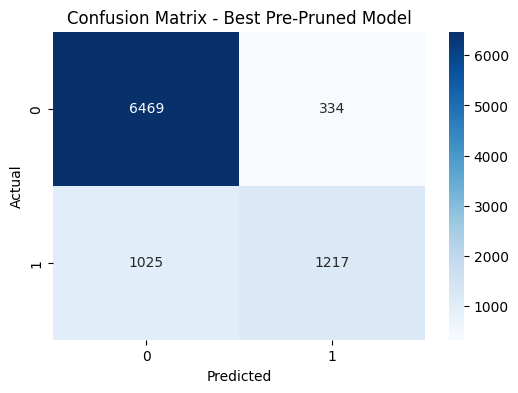

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues',
            xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Best Pre-Pruned Model')
plt.show()

In [61]:
target_labels = target_encoder.classes_.tolist()
print("Best pre-pruned model classification report (test set):")
print(classification_report(y_test_np, best_test_pred, target_names=target_labels))

Best pre-pruned model classification report (test set):
              precision    recall  f1-score   support

       <=50K       0.86      0.95      0.90      6803
        >50K       0.78      0.54      0.64      2242

    accuracy                           0.85      9045
   macro avg       0.82      0.75      0.77      9045
weighted avg       0.84      0.85      0.84      9045



In [ ]:
full_tree = DecisionTreeClassifierScratch(
    criterion=best_config["criterion"],
    max_depth=None,
    min_samples_split=2,
)
full_tree.fit(X_train_np, y_train_np)

full_val_acc = accuracy_score(y_val_np, full_tree.predict(X_val_np))
full_test_pred = full_tree.predict(X_test_np)
full_test_acc = accuracy_score(y_test_np, full_test_pred)
full_precision, full_recall, full_f1, _ = precision_recall_fscore_support(
    y_test_np, full_test_pred, average="binary"
)

pruned_tree = copy.deepcopy(full_tree)
post_prune_val_acc = reduced_error_prune(pruned_tree, X_val_np, y_val_np)
post_prune_test_pred = pruned_tree.predict(X_test_np)
post_test_acc = accuracy_score(y_test_np, post_prune_test_pred)
post_precision, post_recall, post_f1, _ = precision_recall_fscore_support(
    y_test_np, post_prune_test_pred, average="binary"
)
print(
    "full_tree": {
        "val_accuracy": full_val_acc,
        "test_accuracy": full_test_acc,
        "precision": full_precision,
        "recall": full_recall,
        "f1": full_f1,
    },
    "post_pruned_tree": {
        "val_accuracy": post_prune_val_acc,
        "test_accuracy": post_test_acc,
        "precision": post_precision,
        "recall": post_recall,
        "f1": post_f1,
    }
)

{'full_tree': {'val_accuracy': 0.8116983635559487,
  'test_accuracy': 0.8175787728026535,
  'precision': 0.6497975708502024,
  'recall': 0.5727029438001784,
  'f1': 0.6088193456614509},
 'post_pruned_tree': {'val_accuracy': 0.8494029190623618,
  'test_accuracy': 0.8479823106688779,
  'precision': 0.7805825242718447,
  'recall': 0.5379125780553078,
  'f1': 0.6369157644573541}}

In [66]:
feature_usage = collect_feature_usage(full_tree, feature_names)
pd.Series(feature_usage).sort_values(ascending=False).head(10)

fnlwgt            1264
age                930
occupation         281
hours-per-week     240
workclass          185
education           94
native-country      47
marital-status      46
race                45
capital-gain        38
dtype: int64

Comparing with Scikit learn

In [68]:
from sklearn.tree import DecisionTreeClassifier

sk_tree = DecisionTreeClassifier(
    criterion=best_config["criterion"],
    max_depth=best_config["max_depth"],
    min_samples_split=5,
    random_state=42,
)
sk_tree.fit(X_train_np, y_train_np)

sk_test_pred = sk_tree.predict(X_test_np)
sk_test_acc = accuracy_score(y_test_np, sk_test_pred)
sk_precision, sk_recall, sk_f1, _ = precision_recall_fscore_support(
    y_test_np, sk_test_pred, average="binary"
)

{
    "sklearn_tree": {
        "test_accuracy": sk_test_acc,
        "precision": sk_precision,
        "recall": sk_recall,
        "f1": sk_f1,
    }
}

{'sklearn_tree': {'test_accuracy': 0.8497512437810946,
  'precision': 0.784655061250806,
  'recall': 0.5428189116859946,
  'f1': 0.6417084102293699}}

In [69]:
comparison_df = pd.DataFrame(
    [
        {
            "model": "Scratch (best pre-pruned)",
            "criterion": best_config["criterion"],
            "max_depth": best_config["max_depth"],
            "val_accuracy": best_val_acc,
            "test_accuracy": best_test_acc,
            "precision": precision,
            "recall": recall,
            "f1": f1,
        },
        {
            "model": "Scratch (full tree)",
            "criterion": best_config["criterion"],
            "max_depth": None,
            "val_accuracy": full_val_acc,
            "test_accuracy": full_test_acc,
            "precision": full_precision,
            "recall": full_recall,
            "f1": full_f1,
        },
        {
            "model": "Scratch (post-pruned)",
            "criterion": best_config["criterion"],
            "max_depth": None,
            "val_accuracy": post_prune_val_acc,
            "test_accuracy": post_test_acc,
            "precision": post_precision,
            "recall": post_recall,
            "f1": post_f1,
        },
        {
            "model": "sklearn.tree.DecisionTreeClassifier",
            "criterion": best_config["criterion"],
            "max_depth": best_config["max_depth"],
            "val_accuracy": accuracy_score(y_val_np, sk_tree.predict(X_val_np)),
            "test_accuracy": sk_test_acc,
            "precision": sk_precision,
            "recall": sk_recall,
            "f1": sk_f1,
        },
    ]
)
comparison_df

,model,criterion,max_depth,val_accuracy,test_accuracy,precision,recall,f1
0,Scratch (best pre-pruned),gini,6.0,0.848297,0.849751,0.784655,0.542819,0.641708
1,Scratch (full tree),gini,NaN,0.811698,0.817579,0.649798,0.572703,0.608819
2,Scratch (post-pruned),gini,NaN,0.849403,0.847982,0.780583,0.537913,0.636916
3,sklearn.tree.DecisionTreeClassifier,gini,6.0,0.847966,0.849751,0.784655,0.542819,0.641708
